### Bibliotecas

In [ ]:
!pip install scikeras

In [ ]:
#Manipulacion de datos y funciones matemáticas
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import LabelEncoder
from gensim.models import Word2Vec
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import string
from scipy.sparse import csr_matrix

#Modelos
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier

#Exportacion de modelo
import os
import pickle
from pathlib import Path

#Visualizaciones
import seaborn as sns
import matplotlib.pyplot as plt

#Optimización de hiperparametros
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#Metricas para evaluar modelos
import sklearn as sk
from sklearn import metrics, tree
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score, make_scorer, confusion_matrix, classification_report, accuracy_score, confusion_matrix , precision_recall_curve, roc_curve, roc_auc_score
from scipy.stats import randint
from sklearn.linear_model import LogisticRegression

#SVM
from sklearn import svm

#Librerías de TensorFlow y Keras para Redes Neuronales
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
#====================
# Depende de la versión que tengas instalada, debés comentar una de las dos lineas de abajo:

#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from scikeras.wrappers import KerasClassifier
#====================
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier

###Importación de datasets

In [ ]:
ds_training_original = pd.read_csv('./train.csv')
ds_training = ds_training_original.copy(deep=True)
ds_training.drop(columns=['ID'], inplace=True)

ds_testing_original = pd.read_csv('./test.csv')
ds_testing_with_id = ds_testing_original.copy(deep=True)
ds_testing = ds_testing_with_id.drop(columns=['ID'], inplace=False)

Dividimos el set de training para poder testear nuestros modelos.

In [ ]:
x_train_local, x_test_local, y_train_local, y_test_local = train_test_split(ds_training.review_es,
                                                                            ds_training.sentimiento,
                                                                            test_size=0.3,
                                                                            random_state=42,
                                                                            shuffle=True)

## Preprocesamiento
Para entrenar los modelos con el set completo y realizar las predicciones para publicar en Kaggle

In [ ]:
x_local = ds_training.review_es
y_local = ds_training.sentimiento

testing = ds_testing.review_es

Función para quitar los nombres propios
* Quitamos todas las palabras en mayúscula que no se encuentren ni al principio de una oración ni después de un punto.
* Quitamos las que se encuentren entre comillas

In [ ]:
def eliminar_nombres_propios(set_de_datos):

    # Expresión regular para identificar palabras entre comillas
    quotation_pattern = r"['\"].*?['\"]"

    # Expresión regular para identificar las palabras que comienzan con mayúscula
    capital_pattern = r"(?<!\.\s)\b[A-Z][a-zA-Z]*\b"

    # Filtrar las palabras en el set de datos
    set_de_datos_filtrado = []
    for sentence in set_de_datos:
        # Filtrar palabras entre comillas
        filtered_sentence = re.sub(quotation_pattern, '', sentence)

        # Filtrar palabras con mayúscula no al principio de la oración ni seguidas de un punto
        filtered_sentence = re.sub(capital_pattern, '', filtered_sentence)

        set_de_datos_filtrado.append(filtered_sentence)

    return set_de_datos_filtrado

In [ ]:
def eliminar_puntuacion_y_mayusculas(set_de_datos):
    # Lista para almacenar los resultados procesados
    set_de_datos_procesado = []

    # Recorrer cada elemento en el conjunto de datos
    for texto in set_de_datos:
        # Eliminar signos de puntuación
        texto_procesado = texto.translate(str.maketrans("", "", string.punctuation))

        # Convertir letras mayúsculas a minúsculas
        texto_procesado = texto_procesado.lower()

        # Agregar el resultado procesado a la lista
        set_de_datos_procesado.append(texto_procesado)

    return set_de_datos_procesado

In [ ]:
def eliminar_conectores(set_de_datos):
    # Descargar los recursos necesarios de nltk si no están presentes
    nltk.download('punkt')
    nltk.download('stopwords')

    # Obtener lista de palabras vacías (stopwords) en español
    stopwords_es = set(stopwords.words('spanish'))

    # Lista para almacenar los resultados procesados
    set_de_datos_procesado = []

    # Recorrer cada elemento en el conjunto de datos
    for texto in set_de_datos:

        # Tokenizar el set_de_datos en palabras
        palabras = word_tokenize(texto, language='spanish')

        # Filtrar las palabras que no son conectores ni stopwords
        palabras_filtradas = [palabra for palabra in palabras if palabra.lower() not in stopwords_es]

        # Reconstruir el set_de_datos sin los conectores
        texto_procesado = ' '.join(palabras_filtradas)

        # Agregar el resultado procesado a la lista
        set_de_datos_procesado.append(texto_procesado)

    return set_de_datos_procesado

In [ ]:
def filtrado_basico(set_de_datos):

    set_de_datos1 = eliminar_nombres_propios(set_de_datos)
    set_de_datos2 = eliminar_puntuacion_y_mayusculas(set_de_datos1)
    set_de_datos3 = eliminar_conectores(set_de_datos2)

    return set_de_datos3

In [ ]:
x_train_local_filtrado = filtrado_basico(x_train_local)
x_test_local_filtrado = filtrado_basico(x_test_local)
x_local_filtrado = filtrado_basico(x_local)
testing_filtrado = filtrado_basico(testing)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Estás son la cantidad de palabras reducidas del dataset

In [ ]:
def contar_palabras(array_de_arrays):
    contador = 0
    for array in array_de_arrays:
        for subarray in array:
            contador += len(subarray)
    return contador

In [ ]:
cantidad_palabras_filtradas = contar_palabras(x_local_filtrado)
cantidad_palabras_original = contar_palabras(x_local)

palabras_eliminadas = cantidad_palabras_original - cantidad_palabras_filtradas
palabras_eliminadas

30954178

## Representación de palabras

In [ ]:
# Crea una instancia del codificador de etiquetas
label_encoder = LabelEncoder()

# Ajusta y transforma los valores objetivo
y_train_local_encoded = label_encoder.fit_transform(y_train_local)
y_test_local_encoded = label_encoder.fit_transform(y_test_local)

y_test_encoded = label_encoder.fit_transform(y_local)

Con vocabulario reducido:

In [ ]:
tfidf_vectorizer = TfidfVectorizer()
x_train_local_tfidf = tfidf_vectorizer.fit_transform(x_train_local)
x_test_local_tfidf = tfidf_vectorizer.transform(x_test_local)
x_train_full_tfidf = tfidf_vectorizer.transform(x_local)
x_test_full_tfidf = tfidf_vectorizer.transform(testing)

In [ ]:
# Crear el vectorizador TF-IDF con las palabras que van a quedar fuera por alta frecuencia
tfidf_vectorizer_palabras_a_excluir_por_alta_frecuencia = TfidfVectorizer(min_df=0.4)
tfidf_vectorizer_palabras_a_excluir_por_alta_frecuencia.fit(testing)
vocabulary_a_excluir_por_alta_frecuencia = tfidf_vectorizer_palabras_a_excluir_por_alta_frecuencia.vocabulary_
print("tamaño:", len(vocabulary_a_excluir_por_alta_frecuencia))
print(", ".join(vocabulary_a_excluir_por_alta_frecuencia.keys()))

tamaño: 30
la, de, esta, película, es, su, el, que, con, los, más, las, sin, se, en, como, del, por, una, todo, lo, muy, no, cine, para, un, al, pero, si, me


In [ ]:
# Crear el vectorizador TF-IDF con el vocabulario reducido
tfidf_vectorizer_redvoc = TfidfVectorizer(max_df=0.4, max_features=10000) #"redvoc" de reduced vocabulary
tfidf_vectorizer_redvoc.fit(testing)
vocabulary_reducido = tfidf_vectorizer_redvoc.vocabulary_
print("tamaño:", len(vocabulary_reducido))
print(", ".join(vocabulary_reducido.keys()))

tamaño: 10000
mayor, virtud, existencia, hecho, podamos, jugar, tópicos, extremos, patrias, andaluza, vasca, nadie, ni, ponga, grito, cielo, indica, mucho, nuestra, madurez, nación, pese, quien, bueno, hacer, mofa, sobre, vascos, nacionalismo, vasco, grado, ciertas, cuestiones, antes, eran, abiertas, siempre, hago, corrección, porque, andaluces, han, sido, motivo, guasa, nunca, ha, pasado, nada, esto, mismo, planteamiento, ocho, apellidos, valiente, oportuno, oportunista, seguramente, sea, esa, principales, razones, españoles, hemos, masa, casi, precedentes, cines, ver, este, producto, tele, junto, acertada, fecha, estreno, entre, oscar, verano, brutal, ejemplar, campaña, marketing, cual, aplaudo, eso, puedo, celebrar, despropósito, mi, pesar, digo, repito, oscuro, placer, películas, malas, insisto, hay, olvidar, principal, propósito, entretener, problema, suficientemente, mala, friki, disparatada, ser, peli, desgraciadamente, entretenida, mediocridad, desde, punto, vista, precisamente

Luego vectorizamos el texto:

In [ ]:
x_train_local_tfidf_redvoc = tfidf_vectorizer_redvoc.fit_transform(x_train_local)
x_test_local_tfidf_redvoc = tfidf_vectorizer_redvoc.transform(x_test_local)
x_train_full_tfidf_redvoc = tfidf_vectorizer_redvoc.transform(x_local)
x_test_full_tfidf_redvoc = tfidf_vectorizer_redvoc.transform(testing)

 Con vocabulario preprocesado:

In [ ]:
tfidf_vectorizer_preprocesado = TfidfVectorizer()
x_train_local_filtrado_tfidf = tfidf_vectorizer_preprocesado.fit_transform(x_train_local_filtrado)
x_test_local_filtrado_tfidf = tfidf_vectorizer_preprocesado.transform(x_test_local_filtrado)
x_local_filtrado_tfidf = tfidf_vectorizer_preprocesado.transform(x_local_filtrado)
testing_filtrado_tfidf = tfidf_vectorizer_preprocesado.transform(testing_filtrado)

Con vocabulario preprocesado y reducido

In [ ]:
# Crear el vectorizador TF-IDF con las palabras que van a quedar fuera por alta frecuencia
tfidf_vectorizer_palabras_a_excluir_por_alta_frecuencia_preprocesado = TfidfVectorizer(min_df=0.4)
tfidf_vectorizer_palabras_a_excluir_por_alta_frecuencia_preprocesado.fit(testing_filtrado)
vocabulary_a_excluir_por_alta_frecuencia_preprocesado = tfidf_vectorizer_palabras_a_excluir_por_alta_frecuencia_preprocesado.vocabulary_
print("tamaño:", len(vocabulary_a_excluir_por_alta_frecuencia_preprocesado))
print(", ".join(vocabulary_a_excluir_por_alta_frecuencia_preprocesado.keys()))

tamaño: 3
película, cine, si


In [ ]:
# Crear el vectorizador TF-IDF con el vocabulario reducido
tfidf_vectorizer_redvoc_preprocesado = TfidfVectorizer(max_df=0.4, max_features=10000) #"redvoc" de reduced vocabulary
tfidf_vectorizer_redvoc_preprocesado.fit(testing_filtrado)
vocabulary_reducido_preprocesado = tfidf_vectorizer_redvoc_preprocesado.vocabulary_
print("tamaño:", len(vocabulary_reducido_preprocesado))
print(", ".join(vocabulary_reducido_preprocesado.keys()))

tamaño: 10000
mayor, virtud, existencia, hecho, podamos, jugar, tópicos, extremos, patrias, andaluza, vasca, nadie, ponga, grito, cielo, indica, madurez, nación, pese, bueno, hacer, mofa, vascos, nacionalismo, vasco, grado, ciertas, cuestiones, abiertas, siempre, hago, corrección, andaluces, sido, motivo, guasa, nunca, pasado, mismo, planteamiento, valiente, oportuno, oportunista, seguramente, principales, razones, españoles, acudido, masa, casi, precedentes, cines, ver, producto, junto, acertada, fecha, estreno, oscar, verano, brutal, ejemplar, campaña, marketing, aplaudo, puedo, celebrar, despropósito, pesar, digo, repito, insisto, problema, suficientemente, mala, friki, disparatada, ser, desgraciadamente, entretenida, mediocridad, punto, vista, precisamente, palabra, mejor, define, mediocre, simple, sencilla, impersonal, peor, hecha, ganas, interesa, novedoso, sacar, elemento, entorno, totalmente, ajeno, hostil, argumentos, básicos, comedia, sino, principio, demás, elementos, apenas

In [ ]:
x_train_local_tfidf_redvoc_preprocesado = tfidf_vectorizer_redvoc_preprocesado.transform(x_train_local_filtrado)
x_test_local_tfidf_redvoc_preprocesado = tfidf_vectorizer_redvoc_preprocesado.transform(x_test_local_filtrado)
x_train_full_tfidf_redvoc_preprocesado = tfidf_vectorizer_redvoc_preprocesado.transform(x_local_filtrado)
x_test_full_tfidf_redvoc_preprocesado = tfidf_vectorizer_redvoc_preprocesado.transform(testing_filtrado)

## Funciones generales

Función para visualizar estadísticas del modelo

In [ ]:
def metricas(y_pred,y_test):

  print(classification_report(y_test,y_pred))

  cm = confusion_matrix(y_test,y_pred)
  sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('True')

Exportar el modelo

In [ ]:
def exportar_modelo(modelo, nombre_modelo):
    filename = "./models/" + nombre_modelo + '.pickle'
    pickle.dump(modelo, open(filename, "wb"))

Exportar modelo para los que no pudimos guardar ni con pickle ni joblib

In [ ]:
def exportar_modelo_2(modelo, nombre_modelo):

    tf.keras.models.save_model(modelo, nombre_modelo)

Exportar el submission para Kaggle

In [ ]:
def submission_kaggle(prediccion, nombre_archivo):
    ds_submit = pd.DataFrame({'ID': ds_testing_with_id['ID'], 'sentimiento': prediccion})
    folder_path = './submissions/' + nombre_archivo

    # Nos aseguramos de que la carpeta esté creada
    os.makedirs(folder_path, exist_ok=True)

    #Exportamos el archivo para el submit
    filepath = Path(folder_path+'/submit.csv')
    ds_submit.to_csv(filepath, index=False)

In [ ]:
def importar_modelo(modelo_importado, nombre_del_modelo):

    # Especifica la ruta del archivo pickle que contiene el modelo guardado
    ruta_modelo = "./models/" + nombre_del_modelo + '.pickle'

    # Carga el modelo desde el archivo pickle
    with open(ruta_modelo, 'rb') as archivo:
        modelo_importado = pickle.load(archivo)

Importar modelos que no pudimos guardar como pickle ni joblib

In [ ]:
def importar_modelo_2(modelo_importado, nombre_del_modelo):
    modelo_importado = tf.keras.models.load_model(nombre_del_modelo)

#### Para modelos con label encoder:

Ajusta y transforma los valores objetivo

In [ ]:
sentimiento_encoded = label_encoder.fit_transform(ds_training.sentimiento)

Para exportar el modelo que necesite codificacion y general el submit

In [ ]:
def modelo_encoded_para_kaggle(model, nombre):
    #Entrenamos el modelo
    model.fit(ds_training.review_es, sentimiento_encoded)
    #Exportamos el modelo
    filename = "./models/" + nombre + '.pickle'
    pickle.dump(model, open(filename, "wb"))

def modelo_tfidf_encoded_para_kaggle(model, nombre, dataset):
    #Entrenamos el modelo
    model.fit(dataset, sentimiento_encoded)
    #Exportamos el modelo
    filename = "./models/" + nombre + '.pickle'
    pickle.dump(model, open(filename, "wb"))

In [ ]:
def modelo_tfidf_fullvoc_encoded_para_kaggle(model, nombre):
    modelo_tfidf_encoded_para_kaggle(model, nombre, x_train_full_tfidf)

def modelo_tfidf_redvoc_encoded_para_kaggle(model, nombre):
    modelo_tfidf_encoded_para_kaggle(model, nombre, x_train_full_tfidf_redvoc)

def modelo_tfidf_preproc_encoded_para_kaggle(model, nombre):
    modelo_tfidf_encoded_para_kaggle(model, nombre, x_local_filtrado_tfidf)

def modelo_tfidf_redvoc_preproc_encoded_para_kaggle(model, nombre):
    modelo_tfidf_encoded_para_kaggle(model, nombre, x_train_full_tfidf_redvoc_preprocesado)

Para generar los submits para Kaggle

In [ ]:
def submit_decoded_kaggle(model, nombre_archivo):
    y_pred_encoded = model.predict(ds_testing.review_es)
    # Decodifica las etiquetas predichas
    y_pred = label_encoder.inverse_transform(y_pred_encoded)
    ds_submit = pd.DataFrame({'ID': ds_testing_with_id['ID'], 'sentimiento': y_pred})
    ds_submit.head()
    folder_path = './submissions/'+nombre_archivo
    # Nos aseguramos de que la carpeta esté creada
    os.makedirs(folder_path, exist_ok=True)
    #Exportamos el archivo para el submit
    filepath = Path(folder_path+'/submit.csv')
    ds_submit.to_csv(filepath, index=False)

def submit_tfidf_decoded_kaggle(model, nombre_archivo, dataset):
    y_pred_encoded = model.predict(dataset)
    # Decodifica las etiquetas predichas
    y_pred = label_encoder.inverse_transform(y_pred_encoded)
    ds_submit = pd.DataFrame({'ID': ds_testing_with_id['ID'], 'sentimiento': y_pred})
    ds_submit.head()
    folder_path = './submissions/'+nombre_archivo
    # Nos aseguramos de que la carpeta esté creada
    os.makedirs(folder_path, exist_ok=True)
    #Exportamos el archivo para el submit
    filepath = Path(folder_path+'/submit.csv')
    ds_submit.to_csv(filepath, index=False)

In [ ]:
def submit_tfidf_fullvoc_decoded_kaggle(model, nombre_archivo):
    submit_tfidf_decoded_kaggle(model, nombre_archivo, x_test_full_tfidf)

def submit_tfidf_redvoc_decoded_kaggle(model, nombre_archivo):
    submit_tfidf_decoded_kaggle(model, nombre_archivo, x_test_full_tfidf_redvoc)

def submit_tfidf_preproc_decoded_kaggle(model, nombre_archivo):
    submit_tfidf_decoded_kaggle(model, nombre_archivo, testing_filtrado_tfidf)

In [ ]:
def custom_f1_score(y_true, y_pred, pos_label = 1):
  return f1_score(y_true, y_pred, pos_label = pos_label)

f1_bayes = make_scorer(custom_f1_score, pos_label = 'positivo')
f1 = make_scorer(custom_f1_score)

In [ ]:
target = 'sentimiento'

#Predicciones

### Bayes Naive - CountVectorizer

              precision    recall  f1-score   support

    negativo       0.83      0.85      0.84      7411
    positivo       0.85      0.83      0.84      7589

    accuracy                           0.84     15000
   macro avg       0.84      0.84      0.84     15000
weighted avg       0.84      0.84      0.84     15000



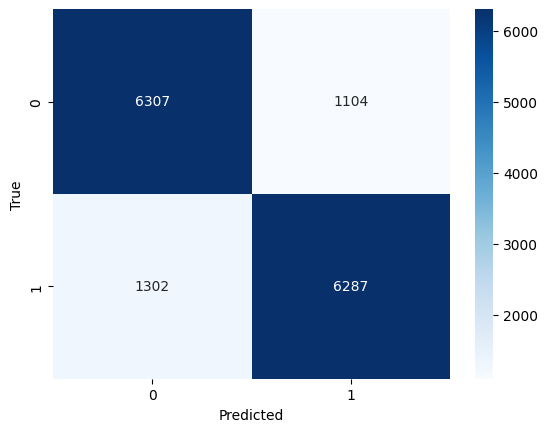

In [ ]:
bayes_naive_cv = make_pipeline(CountVectorizer(), MultinomialNB())
bayes_naive_cv.fit(x_train_local_filtrado, y_train_local)
bayes_naive_cv_y_pred = bayes_naive_cv.predict(x_test_local_filtrado)
metricas(bayes_naive_cv_y_pred,y_test_local)

#### Modelo para Kaggle

In [ ]:
bayes_naive_cv = make_pipeline(CountVectorizer(), MultinomialNB())

bayes_naive_cv.fit(x_local_filtrado, y_local)
exportar_modelo(bayes_naive_cv, 'bayes_naive_cv')

y_pred = bayes_naive_cv.predict(testing_filtrado)
submission_kaggle(y_pred, 'bayes_naive_cv')

### Bayes Naive - TfidfTransformer

              precision    recall  f1-score   support

           0       0.85      0.85      0.85      7411
           1       0.85      0.85      0.85      7589

    accuracy                           0.85     15000
   macro avg       0.85      0.85      0.85     15000
weighted avg       0.85      0.85      0.85     15000



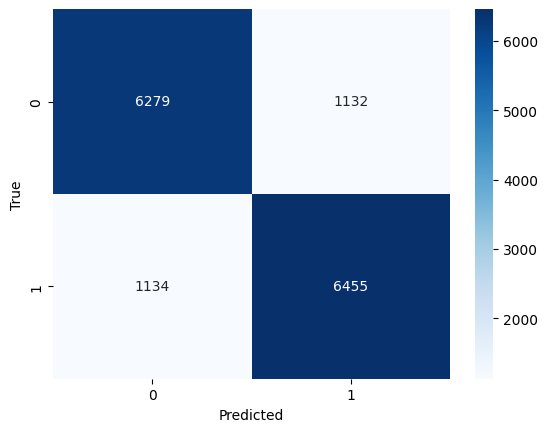

In [ ]:
naive_bayes_tfidf = MultinomialNB()
naive_bayes_tfidf.fit(x_train_local_filtrado_tfidf, y_train_local_encoded)
naive_bayes_tfidf_y_pred = naive_bayes_tfidf.predict(x_test_local_filtrado_tfidf)
metricas(naive_bayes_tfidf_y_pred, y_test_local_encoded)

#### Modelo para Kaggle

In [ ]:
nb = MultinomialNB()
modelo_tfidf_fullvoc_encoded_para_kaggle(nb, 'bayes_naive_tfidf')

### Bayes Naive - TfidfTransformer con vocabulario reducido

              precision    recall  f1-score   support

           0       0.84      0.83      0.84      7411
           1       0.84      0.85      0.84      7589

    accuracy                           0.84     15000
   macro avg       0.84      0.84      0.84     15000
weighted avg       0.84      0.84      0.84     15000



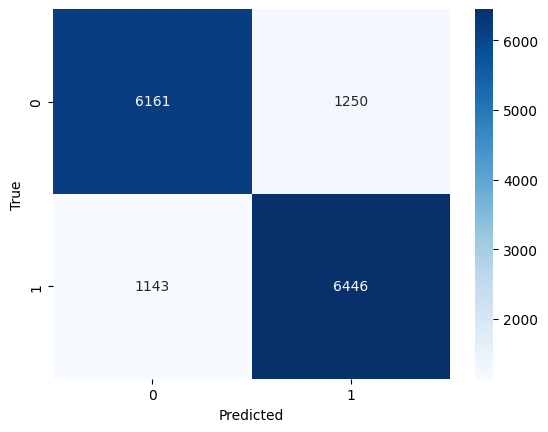

In [ ]:
naive_bayes_tfidf_redvoc = MultinomialNB()
naive_bayes_tfidf_redvoc.fit(x_train_local_tfidf_redvoc, y_train_local_encoded)
naive_bayes_tfidf_redvoc_y_pred = naive_bayes_tfidf_redvoc.predict(x_test_local_tfidf_redvoc)
metricas(naive_bayes_tfidf_redvoc_y_pred, y_test_local_encoded)

#### Modelo para Kaggle

In [ ]:
naive_bayes_tfidf_redvoc_filtrado = MultinomialNB()
naive_bayes_tfidf_redvoc_filtrado.fit(x_local_filtrado_tfidf, y_test_encoded)
naive_bayes_tfidf_redvoc_y_pred_filtrado = naive_bayes_tfidf_redvoc_filtrado.predict(testing_filtrado_tfidf)
naive_bayes_tfidf_redvoc_y_pred_filtrado = label_encoder.inverse_transform(naive_bayes_tfidf_redvoc_y_pred_filtrado)
exportar_modelo(naive_bayes_tfidf_redvoc_filtrado, "bayes_naive_tfidf_preprocesado")
submission_kaggle(naive_bayes_tfidf_redvoc_y_pred_filtrado, "bayes_naive_tfidf_preprocesado")

In [ ]:
naive_bayes_tfidf_redvoc_filtrado2 = MultinomialNB()
naive_bayes_tfidf_redvoc_filtrado2.fit(x_train_full_tfidf_redvoc_preprocesado, y_test_encoded)
naive_bayes_tfidf_redvoc_y_pred_filtrado2 = naive_bayes_tfidf_redvoc_filtrado2.predict(x_test_full_tfidf_redvoc_preprocesado)
naive_bayes_tfidf_redvoc_y_pred_filtrado2 = label_encoder.inverse_transform(naive_bayes_tfidf_redvoc_y_pred_filtrado2)
exportar_modelo(naive_bayes_tfidf_redvoc_filtrado2, "bayes_naive_tfidf_preprocesado_reducido")
submission_kaggle(naive_bayes_tfidf_redvoc_y_pred_filtrado2, "bayes_naive_tfidf_preprocesado_reducido")

### Bayes Naïve - usando TF-IDF - utilizando vocabulario preprocesado

              precision    recall  f1-score   support

           0       0.85      0.85      0.85      7411
           1       0.85      0.85      0.85      7589

    accuracy                           0.85     15000
   macro avg       0.85      0.85      0.85     15000
weighted avg       0.85      0.85      0.85     15000



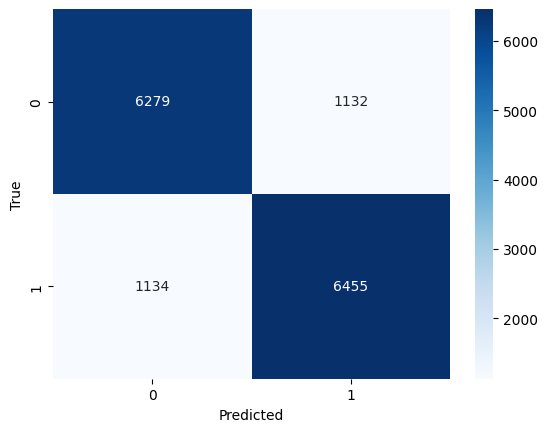

In [ ]:
naive_bayes_tfidf_preproc = MultinomialNB()
naive_bayes_tfidf_preproc.fit(x_train_local_filtrado_tfidf, y_train_local_encoded)
naive_bayes_tfidf_preproc_y_pred = naive_bayes_tfidf_preproc.predict(x_test_local_filtrado_tfidf)
metricas(naive_bayes_tfidf_preproc_y_pred, y_test_local_encoded)

#### Optimización de hiperparámetros

Utilizamos Grid Search para buscar los mejores hiperparámetros optimizando alpha y fit prior.

In [ ]:
naive_bayes = MultinomialNB()

# Definir los hiperparámetros
param_grid = {'alpha': [0.1, 0.5, 1.0, 1.5, 2.0],
              'fit_prior': [True, False]}

grid_search = GridSearchCV(naive_bayes,
                           param_grid,
                           cv=5,
                           verbose=2)
grid_search.fit(x_train_local_filtrado_tfidf, y_train_local_encoded)

# Obtener los mejores hiperparámetros y puntuación
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print('Mejores parámetros encontrados:')
print(best_params)
print('Mejor resultado:')
print(best_score)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ..........................alpha=0.1, fit_prior=True; total time=   0.1s
[CV] END ..........................alpha=0.1, fit_prior=True; total time=   0.1s
[CV] END ..........................alpha=0.1, fit_prior=True; total time=   0.0s
[CV] END ..........................alpha=0.1, fit_prior=True; total time=   0.1s
[CV] END ..........................alpha=0.1, fit_prior=True; total time=   0.1s
[CV] END .........................alpha=0.1, fit_prior=False; total time=   0.0s
[CV] END .........................alpha=0.1, fit_prior=False; total time=   0.0s
[CV] END .........................alpha=0.1, fit_prior=False; total time=   0.1s
[CV] END .........................alpha=0.1, fit_prior=False; total time=   0.0s
[CV] END .........................alpha=0.1, fit_prior=False; total time=   0.0s
[CV] END ..........................alpha=0.5, fit_prior=True; total time=   0.0s
[CV] END ..........................alpha=0.5, fi

              precision    recall  f1-score   support

           0       0.85      0.84      0.85      7411
           1       0.85      0.85      0.85      7589

    accuracy                           0.85     15000
   macro avg       0.85      0.85      0.85     15000
weighted avg       0.85      0.85      0.85     15000



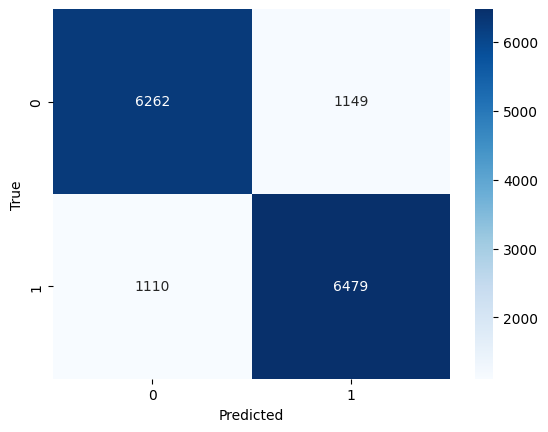

In [ ]:
# Obtener las predicciones con los mejores hiperparámetros
naive_bayes_tfidf_preproc_best = grid_search.best_estimator_
naive_bayes_tfidf_preproc_best_y_pred = naive_bayes_tfidf_preproc_best.predict(x_test_local_filtrado_tfidf)
metricas(naive_bayes_tfidf_preproc_best_y_pred,y_test_local_encoded)

#### Modelo de kaggle

Entrenamos y exportamos el modelo con el set preprocesado de datos y representación TF-IDF

In [ ]:
naive_bayes_tfidf_full_preproc_best = MultinomialNB(alpha=1.0, fit_prior=False)
modelo_tfidf_preproc_encoded_para_kaggle(naive_bayes_tfidf_full_preproc_best, 'naive_bayes_tfidf_preproc_best_full')
submit_tfidf_preproc_decoded_kaggle(naive_bayes_tfidf_full_preproc_best, 'naive_bayes_tfidf_preproc_best_full')

## Random Forest

### Random Forest - Bag of words

Primero probamos un modelo con hiperparámetros por default

In [ ]:
random_forest_default = make_pipeline(CountVectorizer(), RandomForestClassifier())

              precision    recall  f1-score   support

    negativo       0.83      0.85      0.84      7411
    positivo       0.85      0.83      0.84      7589

    accuracy                           0.84     15000
   macro avg       0.84      0.84      0.84     15000
weighted avg       0.84      0.84      0.84     15000



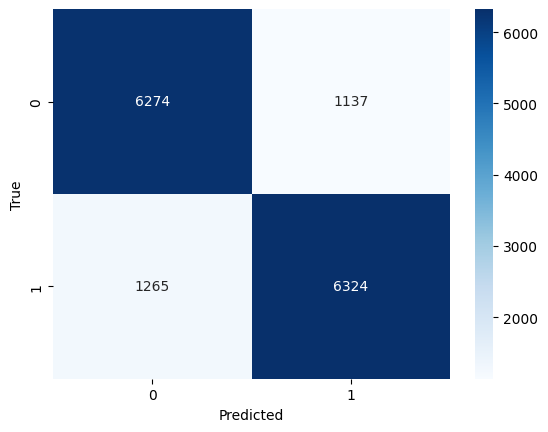

In [ ]:
random_forest_default.fit(x_train_local, y_train_local)
random_forest_default_y_pred = random_forest_default.predict(x_test_local)
metricas(random_forest_default_y_pred,y_test_local)

Probamos con otro modelo

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  2.2min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.0s


              precision    recall  f1-score   support

    negativo       0.83      0.85      0.84      7411
    positivo       0.85      0.83      0.84      7589

    accuracy                           0.84     15000
   macro avg       0.84      0.84      0.84     15000
weighted avg       0.84      0.84      0.84     15000



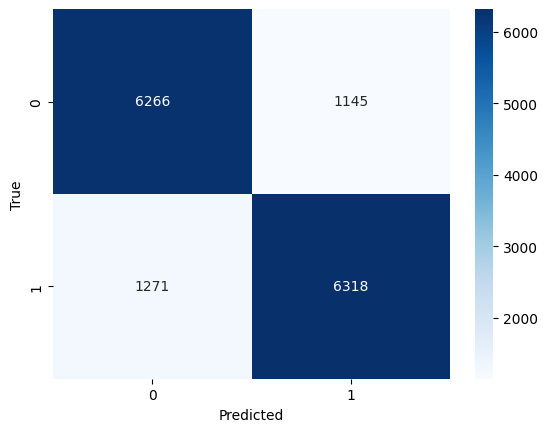

In [ ]:
random_forest_default_filtrado = make_pipeline(CountVectorizer(), RandomForestClassifier(verbose=1))
random_forest_default_filtrado.fit(x_train_local_filtrado, y_train_local)
random_forest_default_filtrado_y_pred = random_forest_default_filtrado.predict(x_test_local_filtrado)
metricas(random_forest_default_filtrado_y_pred,y_test_local)

#### Entrenamiento y exportación para Kaggle

In [ ]:
random_forest_default_kaggle = make_pipeline(CountVectorizer(), RandomForestClassifier())

In [ ]:
random_forest_default_kaggle.fit(x_local, y_local)
exportar_modelo(random_forest_default_kaggle, 'random_forest_default')

In [ ]:
y_pred_random_forest_default = random_forest_default_kaggle.predict(testing)
submission_kaggle(y_pred_random_forest_default, 'random_forest_default')

#### Optimización de hiperparámetros

Vamos a optimizar los hiperparámetros n_estimators y max_depth utilizando Random Search

In [ ]:
param_dist = {
    "randomforestclassifier__n_estimators": randint(100, 500),
    "randomforestclassifier__max_depth": [10, 20, 30],
}

Búsqueda aleatoria de hiperparámetros

In [ ]:
random_search = RandomizedSearchCV(
    random_forest_default,
    param_distributions=param_dist,
    n_iter=5,
    cv=5,
    scoring="accuracy",
    random_state=42,
    verbose=2,
    n_jobs=-1,
)

Ajustamos el modelo con la búsqueda aleatoria de hiperparámetros y mostramos los mejores hiperparámetros y la mejor puntuación obtenida

👇🏼👇🏼👇🏼👇🏼👇🏼 **TARDA 25 MIN!!!!!** 👇🏼👇🏼👇🏼👇🏼👇🏼

In [ ]:
random_search.fit(x_train_local, y_train_local)

print("Mejores hiperparámetros encontrados:")
print(random_search.best_params_)

print("Mejor puntuación durante la búsqueda:")
print(random_search.best_score_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Mejores hiperparámetros encontrados:
{'randomforestclassifier__max_depth': 30, 'randomforestclassifier__n_estimators': 448}
Mejor puntuación durante la búsqueda:
0.8423428571428572


Mostramos los mejores hiperparámetros encontrados

In [ ]:
best_params = random_search.best_params_
best_params

{'randomforestclassifier__max_depth': 30,
 'randomforestclassifier__n_estimators': 448}

Creamos un nuevo modelo con los mejores hiperparámetros

In [ ]:
random_forest_best = make_pipeline(
    CountVectorizer(),
    RandomForestClassifier(max_depth=30, n_estimators=314)
)

              precision    recall  f1-score   support

    negativo       0.85      0.85      0.85      7411
    positivo       0.85      0.85      0.85      7589

    accuracy                           0.85     15000
   macro avg       0.85      0.85      0.85     15000
weighted avg       0.85      0.85      0.85     15000



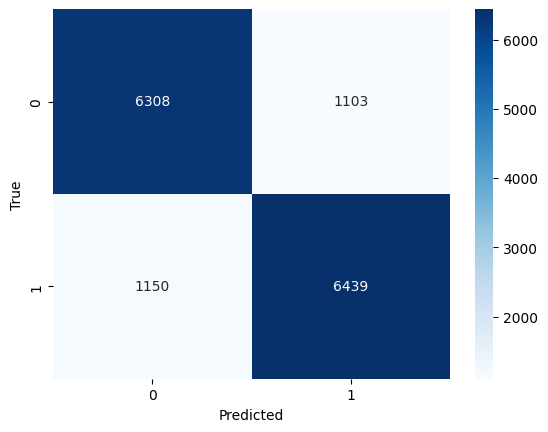

In [ ]:
random_forest_best = make_pipeline(CountVectorizer(), RandomForestClassifier(max_depth=None, n_estimators=314))
random_forest_best.fit(x_train_local, y_train_local)
random_forest_best_y_pred = random_forest_best.predict(x_test_local)
metricas(random_forest_best_y_pred,y_test_local)

#### Modelo para Kaggle

In [ ]:
random_forest_best_kaggle = make_pipeline(CountVectorizer(), RandomForestClassifier(max_depth=30, n_estimators=314))

In [ ]:
random_forest_best_kaggle.fit(x_local, y_local)
exportar_modelo(random_forest_best_kaggle, 'random_forest_opt_1')

In [ ]:
y_pred_random_forest_best_kaggle = random_forest_best_kaggle.predict(testing)
submission_kaggle(y_pred_random_forest_best_kaggle, 'random_forest_opt_1')

## Random Forest TF-IDF

              precision    recall  f1-score   support

           0       0.82      0.85      0.83      7411
           1       0.85      0.82      0.83      7589

    accuracy                           0.83     15000
   macro avg       0.83      0.83      0.83     15000
weighted avg       0.83      0.83      0.83     15000



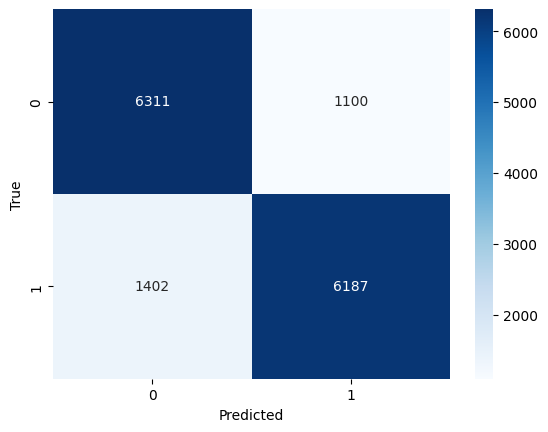

In [ ]:
random_forest_tfidf_default = RandomForestClassifier()
random_forest_tfidf_default.fit(x_train_local_tfidf, y_train_local_encoded)
random_forest_tfidf_default_y_pred = random_forest_tfidf_default.predict(x_test_local_tfidf)
metricas(random_forest_tfidf_default_y_pred, y_test_local_encoded)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.4min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    1.3s finished


              precision    recall  f1-score   support

           0       0.83      0.84      0.84      7411
           1       0.84      0.84      0.84      7589

    accuracy                           0.84     15000
   macro avg       0.84      0.84      0.84     15000
weighted avg       0.84      0.84      0.84     15000



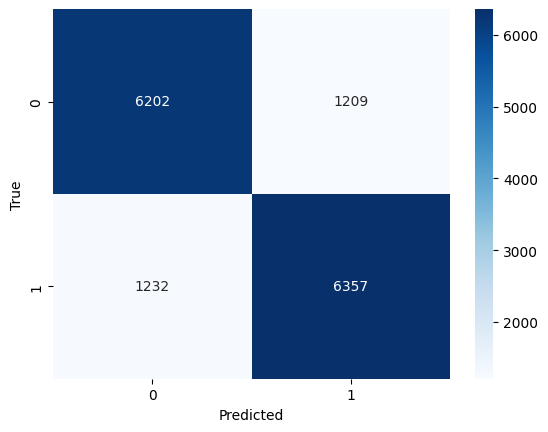

In [ ]:
random_forest_tfidf_preprocesamiento = RandomForestClassifier(verbose=1, n_jobs=-1)
random_forest_tfidf_preprocesamiento.fit(x_train_local_filtrado_tfidf, y_train_local_encoded)
random_forest_tfidf_preprocesamiento_y_pred = random_forest_tfidf_preprocesamiento.predict(x_test_local_filtrado_tfidf)
metricas(random_forest_tfidf_preprocesamiento_y_pred, y_test_local_encoded)

Hiperparametros a optimizar:

In [ ]:
param_dist = {
    'n_estimators': randint(100, 1000),
    'max_depth': randint(5, 50),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'bootstrap': [True, False]
}

In [ ]:
scorer_fn = make_scorer(sk.metrics.f1_score)

base_model = RandomForestClassifier()

Random Search

In [ ]:
random_search = RandomizedSearchCV(base_model,
                                   param_distributions=param_dist,
                                   n_iter=10,
                                   cv=3,
                                   scoring=scorer_fn,
                                   random_state=42,
                                    verbose=2)


In [ ]:
random_search.fit(x_train_local_tfidf, y_train_local_encoded)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END bootstrap=True, max_depth=33, min_samples_leaf=8, min_samples_split=8, n_estimators=221; total time=  57.0s
[CV] END bootstrap=True, max_depth=33, min_samples_leaf=8, min_samples_split=8, n_estimators=221; total time=  56.9s
[CV] END bootstrap=True, max_depth=33, min_samples_leaf=8, min_samples_split=8, n_estimators=221; total time=  56.5s
[CV] END bootstrap=True, max_depth=27, min_samples_leaf=8, min_samples_split=5, n_estimators=971; total time= 3.6min
[CV] END bootstrap=True, max_depth=27, min_samples_leaf=8, min_samples_split=5, n_estimators=971; total time= 3.7min
[CV] END bootstrap=True, max_depth=27, min_samples_leaf=8, min_samples_split=5, n_estimators=971; total time= 3.8min
[CV] END bootstrap=False, max_depth=7, min_samples_leaf=6, min_samples_split=3, n_estimators=443; total time=  43.9s
[CV] END bootstrap=False, max_depth=7, min_samples_leaf=6, min_samples_split=3, n_estimators=443; total time=  43.3s
[CV

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(),
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x78cc760ceef0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x78cc760cf0a0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x78cc760cf6d0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x78cc760dee60>},
                   random_state=42, scoring=make_scorer(f1_score), verbose=2)

In [ ]:
print("Mejores hiperparámetros encontrados:")
print(random_search.best_params_)

print("Mejor puntuación durante la búsqueda:")
print(random_search.best_score_)

Mejores hiperparámetros encontrados:
{'bootstrap': True, 'max_depth': 43, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 700}
Mejor puntuación durante la búsqueda:
0.840703204707964


              precision    recall  f1-score   support

           0       0.85      0.84      0.84      7411
           1       0.84      0.86      0.85      7589

    accuracy                           0.85     15000
   macro avg       0.85      0.85      0.85     15000
weighted avg       0.85      0.85      0.85     15000



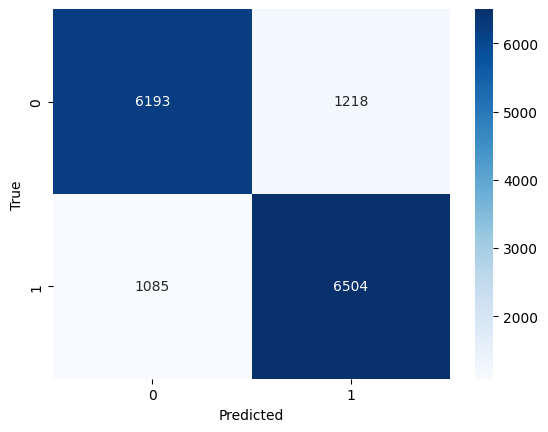

In [ ]:
random_forest_tfidf = RandomForestClassifier(
    bootstrap=True,
    max_depth=43,
    min_samples_leaf=2,
    min_samples_split=5,
    n_estimators=700
)

random_forest_tfidf.fit(x_train_local_tfidf, y_train_local_encoded)
random_forest_tfidf_y_pred = random_forest_tfidf.predict(x_test_local_tfidf)
metricas(random_forest_tfidf_y_pred, y_test_local_encoded)

Kaggle:

In [ ]:
random_forest_tfidf_full = RandomForestClassifier(
    bootstrap=True,
    max_depth=43,
    min_samples_leaf=2,
    min_samples_split=5,
    n_estimators=700
)
modelo_tfidf_fullvoc_encoded_para_kaggle(random_forest_tfidf_full, 'random_forest_tfidf_full')

Random Forest - Words Embeddings

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
stop_words_RF_WE = set(stopwords.words('spanish'))

lemmatizer_RF_WE = WordNetLemmatizer()

In [ ]:
def preprocess_text_RF_WE(text):

    text = text.lower() # Convertir a minúsculas

    tokens = word_tokenize(text) # Tokenización

    tokens = [lemmatizer_RF_WE.lemmatize(token) for token in tokens if token not in stop_words_RF_WE] # Eliminación de stopwords y lematización

    return tokens

In [ ]:
x_train_preprocessed_RF_WE = [preprocess_text_RF_WE(text) for text in x_train_local]
x_test_preprocessed_RF_WE = [preprocess_text_RF_WE(text) for text in x_test_local]

In [ ]:
# Entrenar modelo Word2Vec
modelo_w2v_RF_WE = Word2Vec(x_train_preprocessed_RF_WE,
                            vector_size=200, # El tamaño del vector
                            window=2, # La ventana de contexto
                            min_count=1, # El recuento mínimo de palabras
                            epochs = 10, # El número de épocas
                            negative = 3) # El número de ejemplos negativos

In [ ]:
def get_text_vector_RF_WE(text):
    vector_sum = 0
    for word in text:
        if word in modelo_w2v_RF_WE.wv:
            vector_sum += modelo_w2v_RF_WE.wv[word]
    if vector_sum.ndim > 1:
        return vector_sum.mean(axis=0)
    else:
        return vector_sum

In [ ]:
x_train_vectors_RF_WE = [get_text_vector_RF_WE(text) for text in x_train_preprocessed_RF_WE]
x_test_vectors_RF_WE = [get_text_vector_RF_WE(text) for text in x_test_preprocessed_RF_WE]

In [ ]:
random_forest_WE = make_pipeline(RandomForestClassifier(verbose=2))

In [ ]:
random_forest_WE.fit(x_train_vectors_RF_WE, y_train_local)

y_pred_RF_WE = random_forest_WE.predict(x_test_vectors_RF_WE)

building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   33.7s


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.2s


              precision    recall  f1-score   support

    negativo       0.76      0.76      0.76      7411
    positivo       0.77      0.77      0.77      7589

    accuracy                           0.77     15000
   macro avg       0.77      0.77      0.77     15000
weighted avg       0.77      0.77      0.77     15000



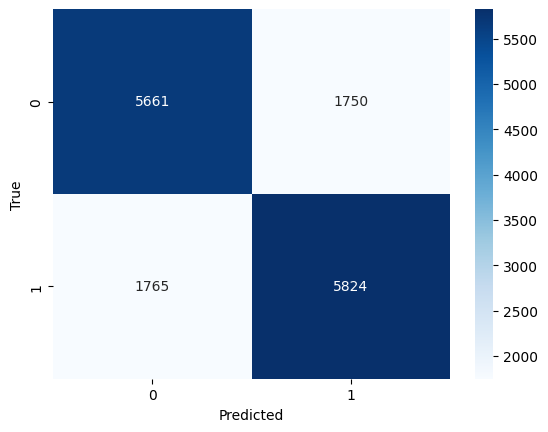

In [ ]:
metricas(y_pred_RF_WE,y_test_local)

Kaggle:

In [ ]:
x_train_preprocessed_RF_WE_kaggle = [preprocess_text_RF_WE(text) for text in x_local]

In [ ]:
modelo_w2v_RF_WE_kaggle = Word2Vec(x_train_preprocessed_RF_WE_kaggle,
                      vector_size=200,
                      window=2,
                      min_count=1,
                      epochs = 10,
                      negative = 3)

In [ ]:
def get_text_vector_RF_WE_kaggle(text):
    vector_sum = 0
    for word in text:
        if word in modelo_w2v_RF_WE_kaggle.wv:
            vector_sum += modelo_w2v_RF_WE_kaggle.wv[word]
    if vector_sum.ndim > 1:
        return vector_sum.mean(axis=0)
    else:
        return vector_sum

In [ ]:
x_train_vectors_RF_WE_kaggle = [get_text_vector_RF_WE_kaggle(text) for text in x_train_preprocessed_RF_WE_kaggle]

random_forest_WE_kaggle = make_pipeline(RandomForestClassifier(verbose=2))

In [ ]:
# Entrenar el modelo con los vectores de texto
random_forest_WE_kaggle.fit(x_train_vectors_RF_WE_kaggle, y_local)

building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   51.5s


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82

Pipeline(steps=[('randomforestclassifier', RandomForestClassifier(verbose=2))])

In [ ]:
test_preprocessed_RF_WE_kaggle = [preprocess_text_RF_WE(text) for text in testing]

In [ ]:
test_vectors_RF_WE_kaggle = [get_text_vector_RF_WE_kaggle(text) for text in test_preprocessed_RF_WE_kaggle]

In [ ]:
y_pred_RF_WE_kaggle = random_forest_WE_kaggle.predict(test_vectors_RF_WE_kaggle)

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s


In [ ]:
exportar_modelo(random_forest_WE_kaggle, "random_forest_WE")
submission_kaggle(y_pred_RF_WE_kaggle, "random_forest_WE")

## XGBoost

In [ ]:
xgb_default = make_pipeline(CountVectorizer(), XGBClassifier())

              precision    recall  f1-score   support

           0       0.85      0.83      0.84      7411
           1       0.84      0.86      0.85      7589

    accuracy                           0.85     15000
   macro avg       0.85      0.85      0.85     15000
weighted avg       0.85      0.85      0.85     15000



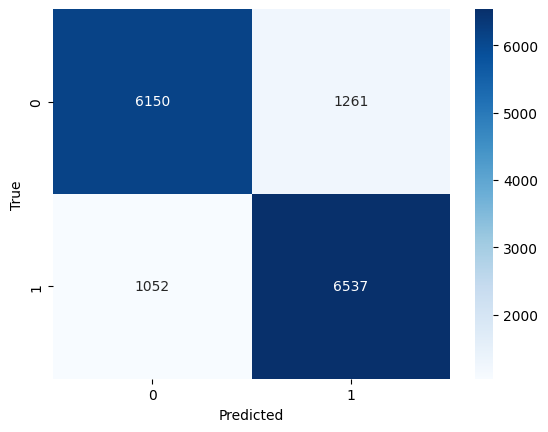

In [ ]:
xgb_default.fit(x_train_local, y_train_local_encoded)
xgb_default_y_pred = xgb_default.predict(x_test_local)
metricas(xgb_default_y_pred,y_test_local_encoded)

In [ ]:
xgb_default_kaggle = make_pipeline(CountVectorizer(), XGBClassifier())

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

y_encoded = label_encoder.fit_transform(y_local)

xgb_default_kaggle.fit(x_local, y_encoded)
exportar_modelo(xgb_default_kaggle, 'xgb_default_kaggle')


In [ ]:
y_pred_xgb = xgb_default_kaggle.predict(testing)
submission_kaggle(y_pred_xgb, 'xgb_default_kaggle')

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [3, 5, 7]
}

scorer_fn = make_scorer(sk.metrics.f1_score)

In [ ]:
xgb1 = RandomizedSearchCV(estimator=XGBClassifier(), param_distributions=param_grid, n_iter=10, cv=5, scoring=scorer_fn, random_state=1, n_jobs=-1, verbose=2)

Usando TF-IDF

              precision    recall  f1-score   support

           0       0.85      0.83      0.84      7411
           1       0.84      0.86      0.85      7589

    accuracy                           0.84     15000
   macro avg       0.84      0.84      0.84     15000
weighted avg       0.84      0.84      0.84     15000



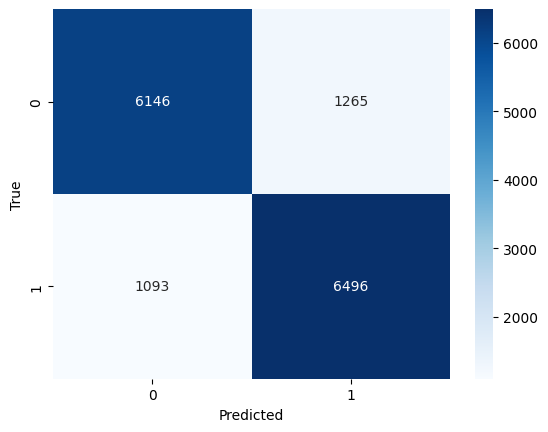

In [ ]:
xgb_tfidf_default = XGBClassifier()
xgb_tfidf_default.fit(x_train_local_tfidf, y_train_local_encoded)
xgb_tfidf_default_y_pred = xgb_tfidf_default.predict(x_test_local_tfidf)
metricas(xgb_tfidf_default_y_pred, y_test_local_encoded)

In [ ]:
xgb = XGBClassifier()
modelo_tfidf_fullvoc_encoded_para_kaggle(xgb, 'xgb_tfidf_full')

Vocabulario reducido

              precision    recall  f1-score   support

           0       0.85      0.82      0.83      7411
           1       0.83      0.86      0.85      7589

    accuracy                           0.84     15000
   macro avg       0.84      0.84      0.84     15000
weighted avg       0.84      0.84      0.84     15000



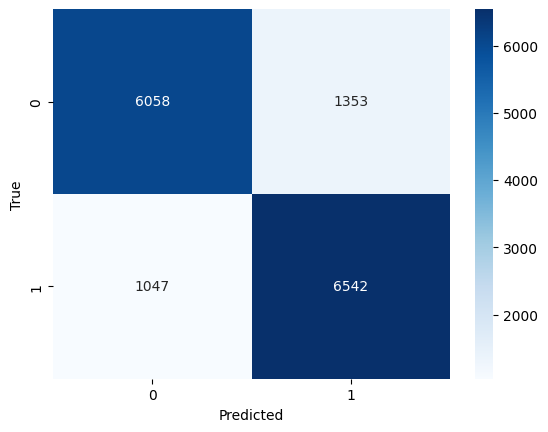

In [ ]:
xgb_tfidf_default_redvoc = XGBClassifier(
    n_jobs=-1,  # Utilizar todos los núcleos de la CPU
    )
xgb_tfidf_default_redvoc.fit(x_train_local_tfidf_redvoc, y_train_local_encoded)
xgb_tfidf_default_redvoc_y_pred = xgb_tfidf_default_redvoc.predict(x_test_local_tfidf_redvoc)
metricas(xgb_tfidf_default_redvoc_y_pred, y_test_local_encoded)

Kaggle:

## Redes Neuronales

In [ ]:
max_words = 1000  # Número máximo de palabras a considerar
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x_train_local)
X_train_seq = tokenizer.texts_to_sequences(x_train_local)
X_test_seq = tokenizer.texts_to_sequences(x_test_local)

In [ ]:
max_sequence_length = 100  # Longitud máxima de la secuencia
X_train_padded = pad_sequences(X_train_seq, maxlen=max_sequence_length)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_sequence_length)

In [ ]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_local)
y_test_encoded = label_encoder.transform(y_test_local)

In [ ]:
from keras.layers import Flatten

embedding_dim = 50  # Dimensión del espacio de embeddings
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(GRU(32))  # Capa GRU con 32 unidades
model.add(Dense(64, activation='relu'))  # Agregar una capa densa adicional
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))  # Capa de salida para clasificación binaria

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(X_train_padded, y_train_encoded, epochs=3, batch_size=32, validation_split=0.2)

Epoch 1/3
875/875 [==============================] - 44s 47ms/step - loss: 0.5079 - accuracy: 0.7415 - val_loss: 0.4004 - val_accuracy: 0.8140
Epoch 2/3
875/875 [==============================] - 39s 45ms/step - loss: 0.3916 - accuracy: 0.8250 - val_loss: 0.3848 - val_accuracy: 0.8240
Epoch 3/3
875/875 [==============================] - 37s 42ms/step - loss: 0.3626 - accuracy: 0.8400 - val_loss: 0.3745 - val_accuracy: 0.8220


In [ ]:
x_test_local_preprocessed = filtrado_basico(x_test_local)

x_test_local_seq = tokenizer.texts_to_sequences(x_test_local_preprocessed)

x_test_local_padded = pad_sequences(x_test_local_seq, maxlen=max_sequence_length)

y_test_local_pred_proba = model.predict(x_test_local_padded)

y_test_local_pred = (y_test_local_pred_proba > 0.5).astype(int)

y_test_local_pred_original = label_encoder.inverse_transform(y_test_local_pred.flatten())

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


469/469 [==============================] - 7s 14ms/step


              precision    recall  f1-score   support

    negativo       0.86      0.77      0.81      7411
    positivo       0.79      0.88      0.83      7589

    accuracy                           0.82     15000
   macro avg       0.83      0.82      0.82     15000
weighted avg       0.83      0.82      0.82     15000



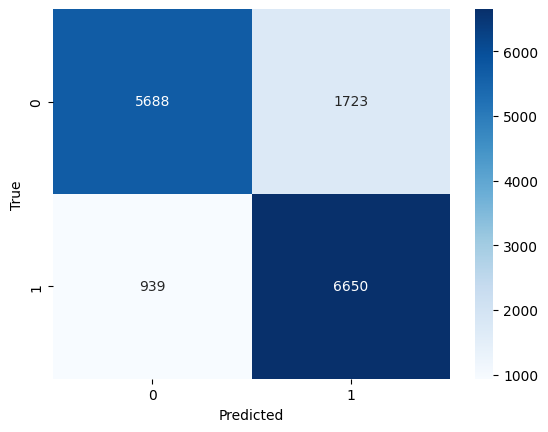

In [ ]:
metricas(y_test_local_pred_original, y_test_local)

In [ ]:
# Aplicar el mismo preprocesamiento a ds_testing
ds_testing_preprocessed = filtrado_basico(ds_testing['review_es'])

ds_testing_seq = tokenizer.texts_to_sequences(ds_testing_preprocessed)

ds_testing_padded = pad_sequences(ds_testing_seq, maxlen=max_sequence_length)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
y_pred_proba = model.predict(ds_testing_padded)

269/269 [==============================] - 3s 11ms/step


In [ ]:
y_pred = (y_pred_proba > 0.5).astype(int)

In [ ]:

y_pred_original = label_encoder.inverse_transform(y_pred.flatten())

In [ ]:
#predicciones
ds_submit = pd.DataFrame({'ID': ds_testing_with_id['ID'], 'sentimiento': y_pred_original})
ds_submit.to_csv('redes_neuronales.csv', index=False)

In [ ]:
exportar_modelo(model, "redes_neuronales1")

## Red Neuronal 2

In [ ]:
max_words = 5000
max_sequence_length = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x_train_local_filtrado)

X_train_seq = tokenizer.texts_to_sequences(x_train_local_filtrado)
X_test_seq = tokenizer.texts_to_sequences(x_test_local_filtrado)

X_train_padded = pad_sequences(X_train_seq, maxlen=max_sequence_length)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_sequence_length)


In [ ]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_local)
y_test_encoded = label_encoder.transform(y_test_local)

In [ ]:
embedding_dim = 50
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(GRU(64, return_sequences=True))
model.add(Dropout(0.5))
model.add(GRU(32))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train_padded, y_train_encoded, epochs=4, batch_size=64, validation_split=0.2)

Epoch 1/4
438/438 [==============================] - 207s 451ms/step - loss: 0.4464 - accuracy: 0.7831 - val_loss: 0.3493 - val_accuracy: 0.8456
Epoch 2/4
438/438 [==============================] - 193s 442ms/step - loss: 0.3021 - accuracy: 0.8783 - val_loss: 0.3274 - val_accuracy: 0.8596
Epoch 3/4
438/438 [==============================] - 151s 344ms/step - loss: 0.2549 - accuracy: 0.9004 - val_loss: 0.3446 - val_accuracy: 0.8550
Epoch 4/4
438/438 [==============================] - 135s 308ms/step - loss: 0.2109 - accuracy: 0.9207 - val_loss: 0.3860 - val_accuracy: 0.8591


In [ ]:
test_loss, test_acc = model.evaluate(X_test_padded, y_test_encoded)
print(f'Test Accuracy: {test_acc * 100:.2f}%')

469/469 [==============================] - 30s 63ms/step - loss: 0.3764 - accuracy: 0.8601
Test Accuracy: 86.01%


469/469 [==============================] - 24s 50ms/step
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      7411
           1       0.87      0.85      0.86      7589

    accuracy                           0.86     15000
   macro avg       0.86      0.86      0.86     15000
weighted avg       0.86      0.86      0.86     15000



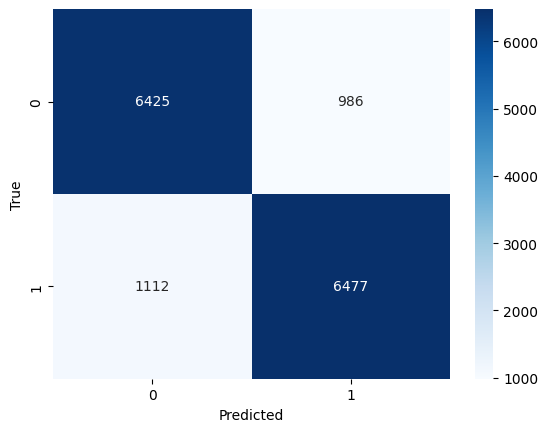

In [ ]:
y_pred = (model.predict(X_test_padded) > 0.5).astype('int').flatten()
metricas(y_pred, y_test_encoded)

In [ ]:
X_seq = tokenizer.texts_to_sequences(ds_testing.review_es)
X_padded = pad_sequences(X_seq, maxlen=max_sequence_length)

In [ ]:
nuevas_predicciones = model.predict(X_padded)
indices_predicciones = (nuevas_predicciones > 0.5).astype('int').flatten()

269/269 [==============================] - 14s 52ms/step


In [ ]:
clasificacion = {0: 'Negativo', 1: 'Positivo'}
predicciones = [clasificacion[i] for i in indices_predicciones]

In [ ]:
predicciones = pd.DataFrame({
    'ID': ds_testing_with_id['ID'],
    'sentimiento': predicciones
})

In [ ]:
predicciones.to_csv('red_neuronal2.csv', index=False)

In [ ]:
exportar_modelo(model, 'red_neuronal2')

In [ ]:
redes_neuronales2 = model

## Ensambles

              precision    recall  f1-score   support

           0       0.84      0.82      0.83      7411
           1       0.83      0.85      0.84      7589

    accuracy                           0.84     15000
   macro avg       0.84      0.84      0.84     15000
weighted avg       0.84      0.84      0.84     15000



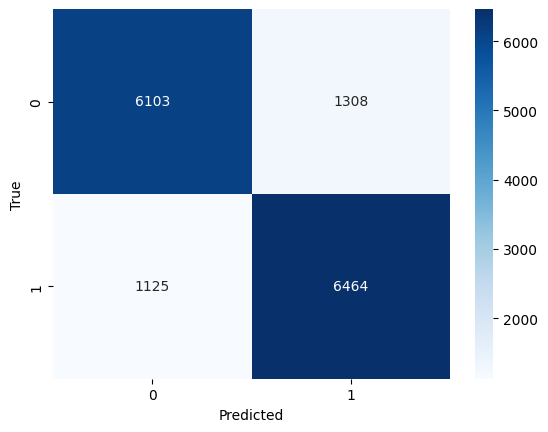

In [ ]:
# Definir los modelos
naive_bayes_model = MultinomialNB()
xgb_model = XGBClassifier()
random_forest_model = RandomForestClassifier()

# Crear el ensamble Hard Voting
ensemble_model = VotingClassifier(estimators=[
    ('naive_bayes', naive_bayes_model),
    ('xgb', xgb_model),
    ('random_forest', random_forest_model)
], voting='hard')

# Entrenar el ensamble
ensemble_model.fit(x_train_local_tfidf_redvoc_preprocesado, y_train_local_encoded)

# Realizar predicciones en el conjunto de prueba
ensemble_preds = ensemble_model.predict(x_test_local_tfidf_redvoc_preprocesado)

# Calcular y mostrar las métricas
metricas(ensemble_preds, y_test_local_encoded)

In [ ]:
# Hacer predicciones en el conjunto de prueba completo (ds_testing)
ensemble_preds_test = ensemble_model.predict(x_test_full_tfidf_redvoc_preprocesado)

# Decodificar las predicciones
ensemble_preds_decoded = label_encoder.inverse_transform(ensemble_preds_test)

# Crear DataFrame para Kaggle
ds_submit = pd.DataFrame({'ID': ds_testing_with_id['ID'], 'sentimiento': ensemble_preds_decoded})

# Verificar si la columna 'ID' está configurada como índice
if ds_submit.index.name == 'ID':
    ds_submit.reset_index(inplace=True)

# Generar archivo Kaggle
submission_kaggle(ds_submit['sentimiento'], 'ensemble_hard_voting')

# Guardar el modelo ensamblado en un archivo pickle
exportar_modelo(ensemble_model, 'ensamble_votacion')

